<a href="https://colab.research.google.com/github/ChaithanyaSaiB/UMBC-DATA606-Capstone/blob/main/notebooks/Exploration_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/content/cnnhealth_transformed.csv')
data

,Content
0,child specter house father myriad concern call...
1,hey dude music anyone take note probably heari...
2,misuse outer garment lead exposure potentially...
3,institute health plan hospital health care wor...
4,man marvel superhero film recently technology ...
...,...
970,pickler lay floor drip sweat trainer bob harpe...
971,expert asperger syndrome expert asperger atten...
972,flashlight center carry flight stair safety ho...
973,brain recently phrase neo matrix proclaim know...


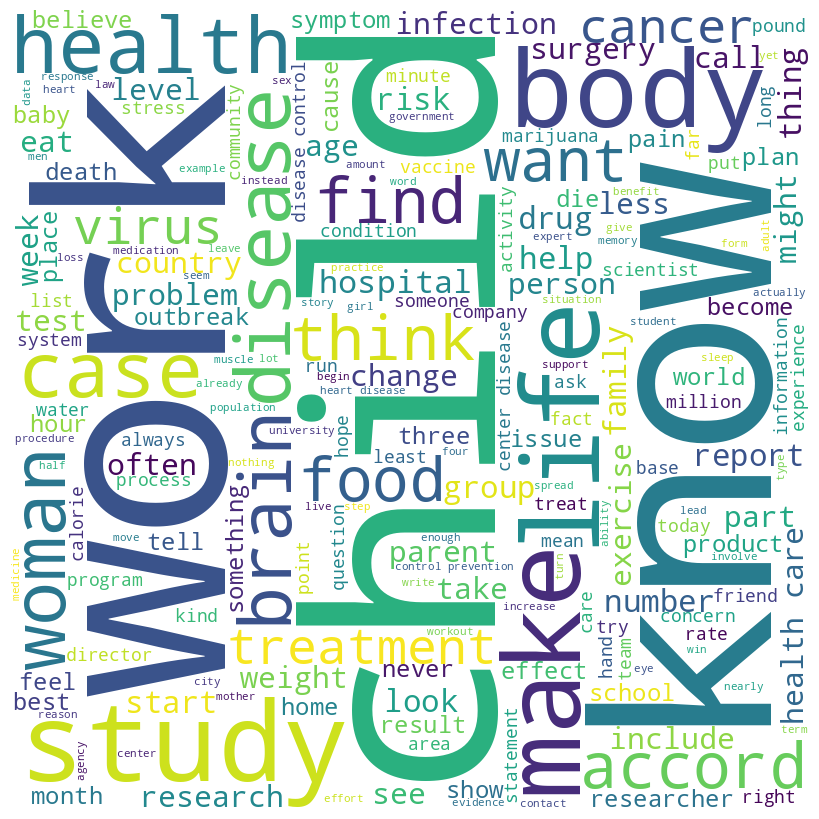

In [3]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                #stopwords = set(STOPWORDS),
                min_font_size = 10).generate(data['Content'].str.cat(sep = ' '))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [4]:
vectorizer = CountVectorizer()
data_transformed = vectorizer.fit_transform(data['Content'])
data_transformed = pd.DataFrame(data_transformed.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index)
data_transformed

,aa,abandon,abandonment,abbey,abbreviate,abbreviation,abdomen,abide,ability,abnormal,...,zipper,zippy,zoll,zombie,zone,zoo,zoom,zoonosis,zoster,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
971,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
973,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data_transformed.stack().value_counts().sort_index()

0     10161735
1       130201
2        26281
3         9691
4         4646
5         2670
6         1487
7         1052
8          674
9          486
10         343
11         266
12         227
13         186
14         152
15         106
16          72
17          84
18          69
19          55
20          40
21          31
22          27
23          41
24          28
25          12
26          47
27          10
28           9
29           9
30           6
31           7
32           3
33           5
34          38
35           9
36           4
37           4
38           2
39           3
40           2
43           1
44           1
45           1
46           3
51          17
52           2
55           1
59           1
61           1
63           1
69           1
Name: count, dtype: int64

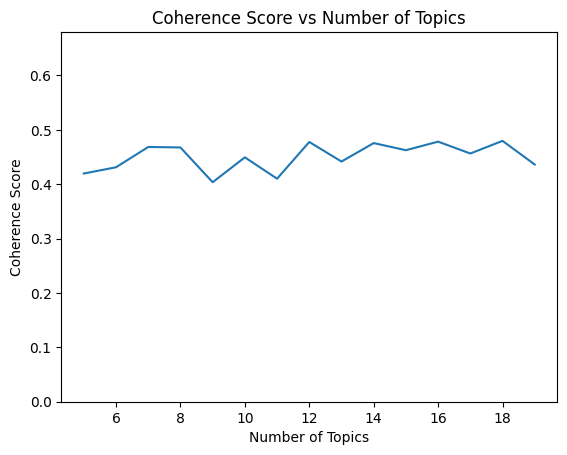

In [6]:
# Tokenize documents
tokenized_documents = [doc.split() for doc in data['Content']]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Create a corpus from the tokenized documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Set range of topics to explore
min_topics = 5
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Run LDA model for different number of topics and compute coherence score
coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot coherence score vs number of topics
plt.plot(topics_range, coherence_scores)
plt.ylim(0, max(coherence_scores)+0.2)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()


In [7]:
# Split data into training and validation sets
train_corpus, val_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

# Define hyperparameters grid
params_grid = {
    'alpha': ['auto', 'symmetric', 'asymmetric'],  # Alpha parameter
    'eta': ['auto', 0.01, 0.1],  # Eta parameter
    'passes': [5, 10, 15],  # Number of passes through the corpus
    'chunksize': [100, 200, 300],  # Number of documents to load into memory at a time
    'random_state': [42, 2022, 999],  # Random seed for reproducibility
}


best_model = None
best_coherence_score = -float('inf')

# Perform grid search
for params in ParameterGrid(params_grid):
    print("Trying parameters:", params)
    lda_model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=7, update_every=1, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print("Coherence Score:", coherence_score)

    # Update best model if coherence score improves
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score

print("Best Model Parameters:", best_model.get_topics())
print("Best Coherence Score:", best_coherence_score)

Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5, 'random_state': 42}
Coherence Score: 0.47354012195739975
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5, 'random_state': 2022}
Coherence Score: 0.4882043939113064
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5, 'random_state': 999}
Coherence Score: 0.46195032742087017
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10, 'random_state': 42}
Coherence Score: 0.4915087102538863
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10, 'random_state': 2022}
Coherence Score: 0.48971180189446434
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10, 'random_state': 999}
Coherence Score: 0.46508654106473835
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 15, 'random_state': 42}
Coherence Score: 0.49104071580179864
Trying param

In [8]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=100, passes=15, alpha='asymmetric', eta=0.1, random_state=2022)

# Print topics
pprint(lda_model.print_topics())


[(0,
  '0.027*"health" + 0.023*"care" + 0.013*"hospital" + 0.010*"would" + '
  '0.010*"insurance" + 0.009*"family" + 0.008*"also" + 0.008*"marijuana" + '
  '0.007*"plan" + 0.007*"accord"'),
 (1,
  '0.019*"case" + 0.018*"disease" + 0.018*"health" + 0.017*"virus" + '
  '0.016*"infection" + 0.015*"water" + 0.012*"accord" + 0.012*"symptom" + '
  '0.011*"flu" + 0.010*"air"'),
 (2,
  '0.030*"food" + 0.020*"weight" + 0.016*"pound" + 0.014*"eat" + 0.013*"body" '
  '+ 0.010*"product" + 0.009*"calorie" + 0.009*"exercise" + 0.008*"make" + '
  '0.008*"also"'),
 (3,
  '0.046*"surgery" + 0.023*"sleep" + 0.023*"procedure" + 0.021*"surgeon" + '
  '0.018*"hour" + 0.018*"device" + 0.017*"seizure" + 0.014*"blood" + '
  '0.011*"injury" + 0.011*"body"'),
 (4,
  '0.035*"cancer" + 0.029*"drug" + 0.022*"disease" + 0.016*"cell" + '
  '0.012*"treatment" + 0.011*"vaccine" + 0.011*"transplant" + 0.010*"baby" + '
  '0.010*"world" + 0.009*"case"'),
 (5,
  '0.040*"s" + 0.013*"illness" + 0.013*"family" + 0.011*"life"

**Topics and their keywords**

1. **Vaccination and Measles**:health, care, hospital, would, insurance, family, also, marijuana, plan, accord

2. **Medical Treatments and Marijuana**: case, disease, health, virus, infection, water, accord, symptom, flu, air

3. **Health Research and Findings**: food, weight, pound, eat, body, product, calorie, exercise, make, also

4. **Childhood Mental Health and Education**: surgery, sleep, procedure, surgeon, hour, device, seizure, blood, injury, body

5. **Infectious Diseases and Hygiene**: cancer, drug, disease, cell, treatment, vaccine, transplant, baby, world, case

6. **Food and Nutrition**: s, illness, family, life, son, would, mother, thing, home, child

7. **Family Health and Illness**: study, brain, child, also, heart, find, woman, age, life, research

In [9]:
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]
for i, doc_topics in enumerate(document_topic_distribution):
    print(f"Document {i}: {doc_topics}")

Document 0: [(0, 0.19942911), (1, 0.068374015), (2, 0.07994002), (5, 0.08639668), (6, 0.5652004)]
Document 1: [(0, 0.09292958), (1, 0.26000395), (2, 0.024050592), (3, 0.16315505), (5, 0.03723542), (6, 0.42210817)]
Document 2: [(1, 0.5282225), (3, 0.24775034), (4, 0.09489917), (6, 0.1255134)]
Document 3: [(0, 0.42498156), (1, 0.47354588), (4, 0.09431768)]
Document 4: [(0, 0.032171946), (4, 0.033125542), (5, 0.36320013), (6, 0.5677986)]
Document 5: [(0, 0.08084828), (1, 0.06490414), (2, 0.018177863), (4, 0.06625725), (6, 0.7689282)]
Document 6: [(1, 0.6678706), (3, 0.13142553), (4, 0.19227481)]
Document 7: [(0, 0.19942842), (1, 0.068373926), (2, 0.07993972), (5, 0.08639702), (6, 0.5652011)]
Document 8: [(0, 0.2552847), (1, 0.023301436), (2, 0.13400029), (3, 0.028947879), (4, 0.019638512), (5, 0.12534297), (6, 0.4134842)]
Document 9: [(1, 0.1192619), (2, 0.13917875), (4, 0.13963), (5, 0.24346684), (6, 0.3545229)]
Document 10: [(0, 0.08286725), (2, 0.09140148), (5, 0.4273866), (6, 0.396768

In [13]:
import joblib
joblib.dump(lda_model, "lda_model.sav")
dictionary.save('dictionary.sav')

In [11]:
topic_names = [
    "Vaccination and Measles",
    "Medical Treatments and Marijuana",
    "Health Research and Findings",
    "Childhood Mental Health and Education",
    "Infectious Diseases and Hygiene",
    "Food and Nutrition",
    "Family Health and Illness",
    "Personal Health and Weight Management",
    "Healthcare System and Cases"
]


# Initialize defaultdict to store topic frequencies
topic_frequencies = defaultdict(float)

# Aggregate probabilities for each topic across all documents
for doc_topics in document_topic_distribution:
    for topic, prob in doc_topics:
        topic_frequencies[topic] += prob

# Calculate frequencies by dividing the aggregated probabilities by the number of documents
num_documents = len(document_topic_distribution)
topic_frequencies = {topic: freq / num_documents for topic, freq in topic_frequencies.items()}

sorted_topic_frequencies = sorted(topic_frequencies.items())
topic_frequencies = [tup[1] for tup in sorted_topic_frequencies]

for topic, value in zip(topic_names,topic_frequencies):
  print("{} topic has {:.2f} average probability in documents".format(topic, value))

Vaccination and Measles topic has 0.15 average probability in documents
Medical Treatments and Marijuana topic has 0.13 average probability in documents
Health Research and Findings topic has 0.15 average probability in documents
Childhood Mental Health and Education topic has 0.03 average probability in documents
Infectious Diseases and Hygiene topic has 0.11 average probability in documents
Food and Nutrition topic has 0.14 average probability in documents
Family Health and Illness topic has 0.29 average probability in documents


In [12]:
import plotly.graph_objects as go

# Create horizontal bar chart
fig = go.Figure(go.Bar(
    x=topic_frequencies,
    y=topic_names,
    orientation='h'
))

# Customize layout
fig.update_layout(
    title='Topics and their average probabilities',
    xaxis_title='Probabilities',
    yaxis_title='Topics',
    yaxis=dict(autorange='reversed', tickmode='linear')  # Reverse the order of categories for horizontal bar chart
)

# Show plot
fig.show()
